In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/train.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8990 entries, 0 to 8989
Data columns (total 98 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date_id                        8990 non-null   int64  
 1   D1                             8990 non-null   int64  
 2   D2                             8990 non-null   int64  
 3   D3                             8990 non-null   int64  
 4   D4                             8990 non-null   int64  
 5   D5                             8990 non-null   int64  
 6   D6                             8990 non-null   int64  
 7   D7                             8990 non-null   int64  
 8   D8                             8990 non-null   int64  
 9   D9                             8990 non-null   int64  
 10  E1                             7206 non-null   float64
 11  E10                            7984 non-null   float64
 12  E11                            7984 non-null   f

In [4]:
df_train.head()

date_id  D1  D2  D3  D4  D5  D6  D7  D8  D9  ...  V3  V4  V5  V6  V7  V8  \
0        0   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
1        1   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
2        2   0   0   0   1   0   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
3        3   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   
4        4   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   

   V9  forward_returns  risk_free_rate  market_forward_excess_returns  
0 NaN        -0.002421        0.000301                      -0.003038  
1 NaN        -0.008495        0.000303                      -0.009114  
2 NaN        -0.009624        0.000301                      -0.010243  
3 NaN         0.004662        0.000299                       0.004046  
4 NaN        -0.011686        0.000299                      -0.012301  

[5 rows x 98 columns]

# Feature Engneering

In [5]:
import math

col_na = []
for col, i in df_train.isna().sum().items():
    if (i!=0): col_na.append(col)

for col in col_na:
    if (math.isnan(df_train[col][0])):
        df_train[col][0] = 0
for col in col_na:
    while (df_train[col].isna().sum() > 0):
        df_train[col] = df_train[col].fillna(method='ffill')

In [6]:
col = df_train.columns.tolist()
col1 = df_train.columns.tolist()
col.remove('forward_returns',)
col.remove('risk_free_rate')
col.remove('market_forward_excess_returns')
col.remove('date_id')
col1.remove('forward_returns',)
col1.remove('risk_free_rate')
col1.remove('market_forward_excess_returns')
col1.remove('date_id')

In [7]:
for i in col:
    df_train[f'{i}_20leg_mean'] = df_train[i].rolling(window=20).mean()
    df_train[f'{i}_20leg_std'] = df_train[i].rolling(window=20).std()

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8990 entries, 0 to 8989
Columns: 286 entries, date_id to V9_20leg_std
dtypes: float64(276), int64(10)
memory usage: 19.6 MB


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65060
[LightGBM] [Info] Number of data points in the train set: 8990, number of used features: 282
[LightGBM] [Info] Start training from score 0.000051
ÌõàÎ†®ÎÅù
ÌîºÏ≤ò Ï§ëÏöîÎèÑ


<Figure size 1000x800 with 0 Axes>

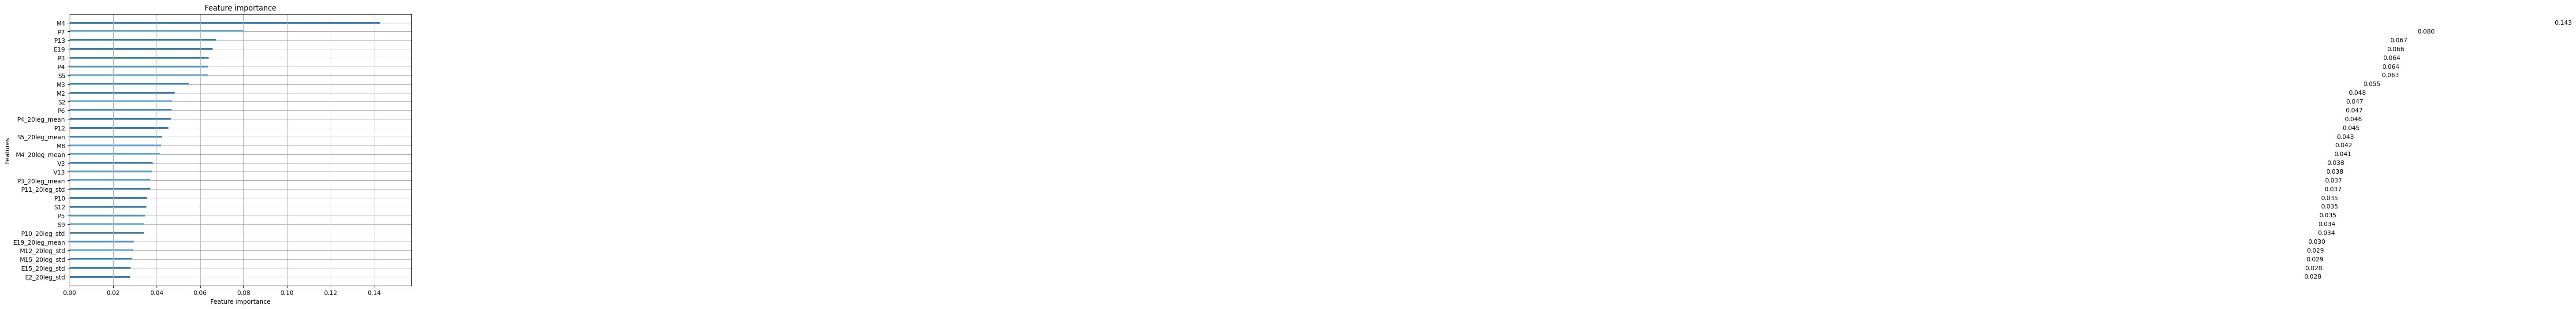

In [9]:
import lightgbm as lgb
import matplotlib.pyplot as plt

label = 'market_forward_excess_returns'
X = df_train.drop([label,'forward_returns', 'risk_free_rate','date_id'], axis=1)
y = df_train[label]

model = lgb.LGBMRegressor(n_estimators=200, n_jobs=1, seed=42)

model.fit(X, y)
print("ÌõàÎ†®ÎÅù")
print("ÌîºÏ≤ò Ï§ëÏöîÎèÑ")
plt.figure(figsize=(10,8))
lgb.plot_importance(
    model,
    max_num_features=30,
    importance_type='gain',
    figsize=(10,8)
)
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 84440
[LightGBM] [Info] Number of data points in the train set: 8990, number of used features: 358
[LightGBM] [Info] Start training from score 0.000051
ÌõàÎ†®ÎÅù
ÌîºÏ≤ò Ï§ëÏöîÎèÑ


<Figure size 1000x800 with 0 Axes>

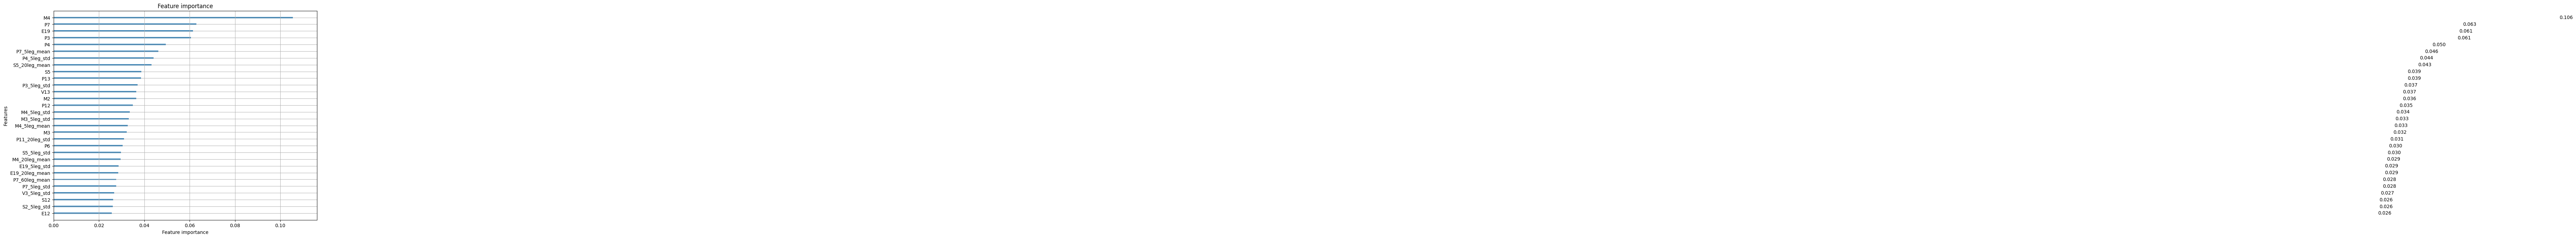

In [10]:
good_col = ['M4','P7','P13','E19','P3','P4','S5','M3','M2','S2','P6','P12','M8','V3','V13','P10','S12','P5','S9']

for i in good_col:
    df_train[f'{i}_5leg_mean'] = df_train[i].rolling(window=5).mean()
    df_train[f'{i}_60leg_mean'] = df_train[i].rolling(window=60).mean()
    df_train[f'{i}_5leg_std'] = df_train[i].rolling(window=5).std()
    df_train[f'{i}_60leg_std'] = df_train[i].rolling(window=60).std()

label = 'market_forward_excess_returns'
X = df_train.drop([label,'forward_returns', 'risk_free_rate','date_id'], axis=1)
y = df_train[label]

model = lgb.LGBMRegressor(n_estimators=200, n_jobs=1, seed=42)

model.fit(X, y)
print("ÌõàÎ†®ÎÅù")
print("ÌîºÏ≤ò Ï§ëÏöîÎèÑ")
plt.figure(figsize=(10,8))
lgb.plot_importance(
    model,
    max_num_features=30,
    importance_type='gain',
    figsize=(10,8)
)
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118156
[LightGBM] [Info] Number of data points in the train set: 8990, number of used features: 508
[LightGBM] [Info] Start training from score 0.000051
ÌõàÎ†®ÎÅù
ÌîºÏ≤ò Ï§ëÏöîÎèÑ


<Figure size 1000x800 with 0 Axes>

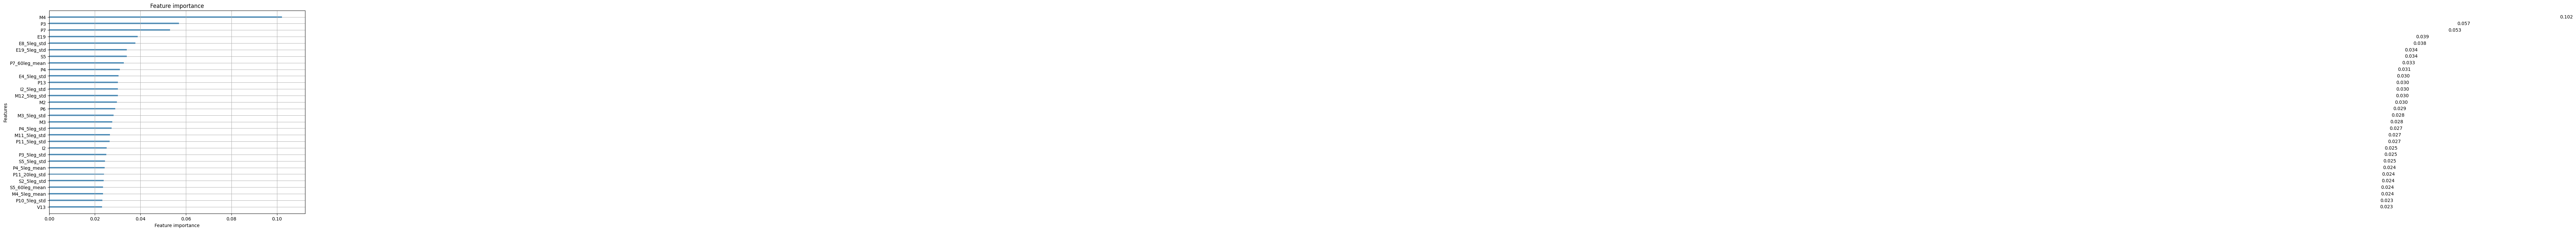

In [11]:
for i in col1:
    df_train[f'{i}_5leg_mean'] = df_train[i].rolling(window=5).mean()
    df_train[f'{i}_5leg_std'] = df_train[i].rolling(window=5).std()

model = lgb.LGBMRegressor(n_estimators=200, n_jobs=1, seed=42)
X = df_train.drop([label,'forward_returns', 'risk_free_rate','date_id'], axis=1)
y = df_train[label]

model.fit(X, y)
print("ÌõàÎ†®ÎÅù")
print("ÌîºÏ≤ò Ï§ëÏöîÎèÑ")
plt.figure(figsize=(10,8))
lgb.plot_importance(
    model,
    max_num_features=30,
    importance_type='gain',
    figsize=(10,8)
)
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118411
[LightGBM] [Info] Number of data points in the train set: 8990, number of used features: 509
[LightGBM] [Info] Start training from score 0.000051
ÌõàÎ†®ÎÅù
ÌîºÏ≤ò Ï§ëÏöîÎèÑ


<Figure size 1000x800 with 0 Axes>

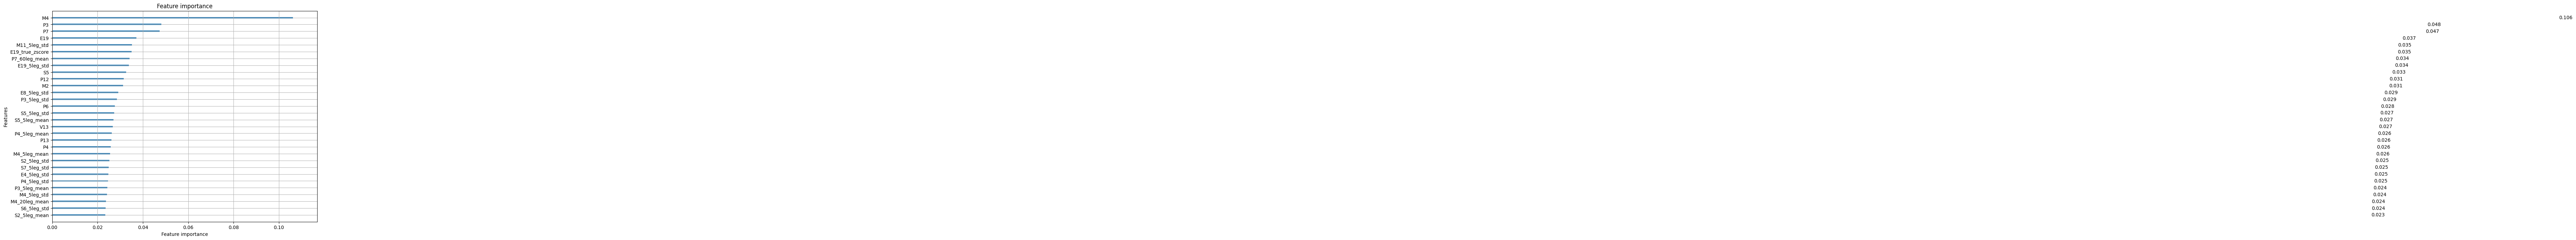

In [12]:
# 5Ïùº Ïù¥ÎèôÌèâÍ∑†
e19_mean_5d = df_train['E19'].rolling(window=5).mean()
# 5Ïùº Ïù¥ÎèôÎ≥ÄÎèôÏÑ±
e19_std_5d = df_train['E19'].rolling(window=5).std()

# "ÏßÑÏßú Z-score"
df_train['E19_true_zscore'] = (df_train['E19'] - e19_mean_5d) / e19_std_5d

model = lgb.LGBMRegressor(n_estimators=200, n_jobs=1, seed=42)
X = df_train.drop([label,'forward_returns', 'risk_free_rate','date_id'], axis=1)
y = df_train[label]

model.fit(X, y)
print("ÌõàÎ†®ÎÅù")
print("ÌîºÏ≤ò Ï§ëÏöîÎèÑ")
plt.figure(figsize=(10,8))
lgb.plot_importance(
    model,
    max_num_features=30,
    importance_type='gain',
    figsize=(10,8)
)
plt.tight_layout()
plt.show()

In [13]:
print(f"ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: {df_train.shape}")
df_train_clean = df_train.dropna()
print(f"NaN Ï†úÍ±∞ ÌõÑ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: {df_train_clean.shape}")

ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: (8990, 513)
NaN Ï†úÍ±∞ ÌõÑ Îç∞Ïù¥ÌÑ∞ ÌÅ¨Í∏∞: (7984, 513)


Íπ®ÎÅóÌïú Îç∞Ïù¥ÌÑ∞Î°ú ÌõàÎ†® ÏãúÏûë...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118374
[LightGBM] [Info] Number of data points in the train set: 7984, number of used features: 509
[LightGBM] [Info] Start training from score 0.000069
ÌõàÎ†® ÎÅù


<Figure size 1000x800 with 0 Axes>

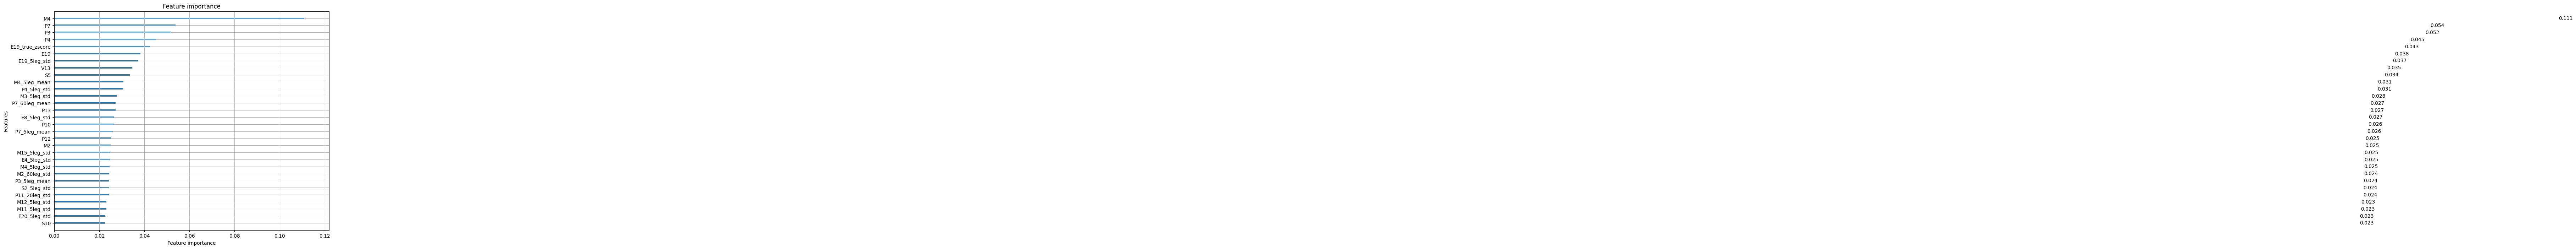

In [14]:
X_clean = df_train_clean.drop([label,'forward_returns', 'risk_free_rate','date_id'], axis=1)
y_clean = df_train_clean[label]

print("Íπ®ÎÅóÌïú Îç∞Ïù¥ÌÑ∞Î°ú ÌõàÎ†® ÏãúÏûë...")
model.fit(X_clean, y_clean) # <--- X_clean, y_clean ÏÇ¨Ïö©
print("ÌõàÎ†® ÎÅù")

plt.figure(figsize=(10,8))
lgb.plot_importance(
    model,
    max_num_features=30,
    importance_type='gain',
    figsize=(10,8)
)
plt.tight_layout()
plt.show()

Íπ®ÎÅóÌïú Îç∞Ïù¥ÌÑ∞Î°ú ÌõàÎ†® ÏãúÏûë...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119139
[LightGBM] [Info] Number of data points in the train set: 7984, number of used features: 512
[LightGBM] [Info] Start training from score 0.000069
ÌõàÎ†® ÎÅù


<Figure size 1000x800 with 0 Axes>

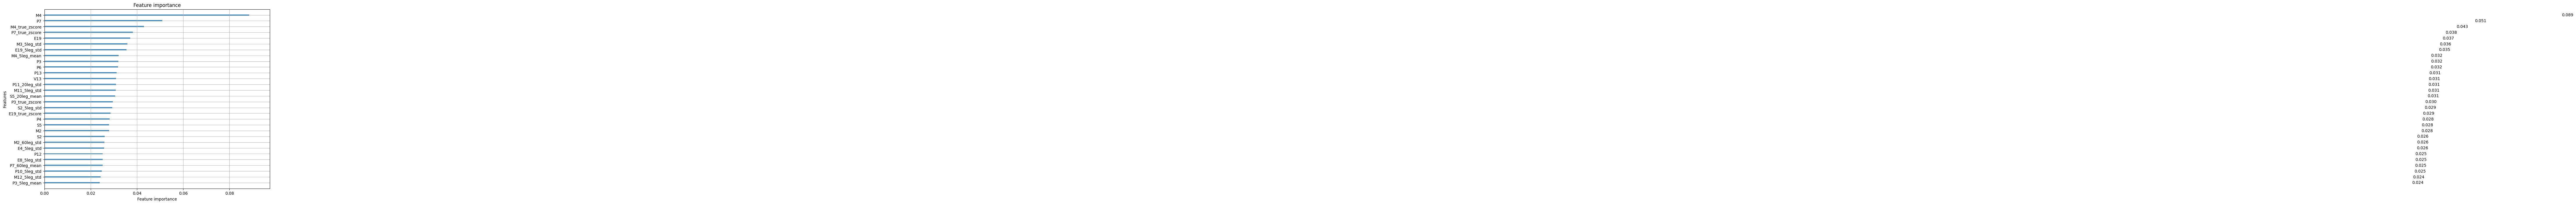

In [15]:
df_clean = df_train_clean

# M4 Z-score (5Ïùº Í∏∞Ï§Ä)
df_clean['M4_true_zscore'] = (df_clean['M4'] - df_clean['M4'].rolling(5).mean()) / df_clean['M4'].rolling(5).std()

# P7 Z-score (5Ïùº Í∏∞Ï§Ä)
df_clean['P7_true_zscore'] = (df_clean['P7'] - df_clean['P7'].rolling(5).mean()) / df_clean['P7'].rolling(5).std()

# P3 Z-score (5Ïùº Í∏∞Ï§Ä)
df_clean['P3_true_zscore'] = (df_clean['P3'] - df_clean['P3'].rolling(5).mean()) / df_clean['P3'].rolling(5).std()

X_clean = df_clean.drop([label,'forward_returns', 'risk_free_rate','date_id'], axis=1)
y_clean = df_clean[label]

print("Íπ®ÎÅóÌïú Îç∞Ïù¥ÌÑ∞Î°ú ÌõàÎ†® ÏãúÏûë...")
model.fit(X_clean, y_clean) # <--- X_clean, y_clean ÏÇ¨Ïö©
print("ÌõàÎ†® ÎÅù")

plt.figure(figsize=(10,8))
lgb.plot_importance(
    model,
    max_num_features=30,
    importance_type='gain',
    figsize=(10,8)
)
plt.tight_layout()
plt.show()

Íπ®ÎÅóÌïú Îç∞Ïù¥ÌÑ∞Î°ú ÌõàÎ†® ÏãúÏûë...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 119904
[LightGBM] [Info] Number of data points in the train set: 7984, number of used features: 515
[LightGBM] [Info] Start training from score 0.000069
ÌõàÎ†® ÎÅù


<Figure size 1000x800 with 0 Axes>

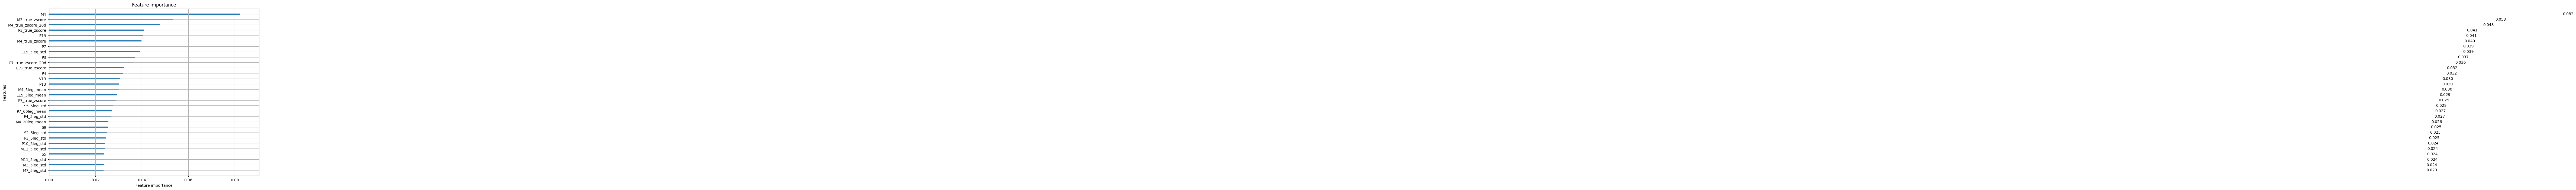

In [16]:
df_clean['M3_true_zscore'] = (df_clean['M3'] - df_clean['M3'].rolling(5).mean()) / df_clean['M3'].rolling(5).std()

df_clean['M4_true_zscore_20d'] = (df_clean['M4'] - df_clean['M4'].rolling(20).mean()) / df_clean['M4'].rolling(20).std()

df_clean['P7_true_zscore_20d'] = (df_clean['P7'] - df_clean['P7'].rolling(20).mean()) / df_clean['P7'].rolling(20).std()

X_clean = df_clean.drop([label,'forward_returns', 'risk_free_rate','date_id'], axis=1)
y_clean = df_clean[label]

print("Íπ®ÎÅóÌïú Îç∞Ïù¥ÌÑ∞Î°ú ÌõàÎ†® ÏãúÏûë...")
model.fit(X_clean, y_clean) # <--- X_clean, y_clean ÏÇ¨Ïö©
print("ÌõàÎ†® ÎÅù")

plt.figure(figsize=(10,8))
lgb.plot_importance(
    model,
    max_num_features=30,
    importance_type='gain',
    figsize=(10,8)
)
plt.tight_layout()
plt.show()

Íπ®ÎÅóÌïú Îç∞Ïù¥ÌÑ∞Î°ú ÌõàÎ†® ÏãúÏûë...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120924
[LightGBM] [Info] Number of data points in the train set: 7984, number of used features: 519
[LightGBM] [Info] Start training from score 0.000069
ÌõàÎ†® ÎÅù


<Figure size 1000x800 with 0 Axes>

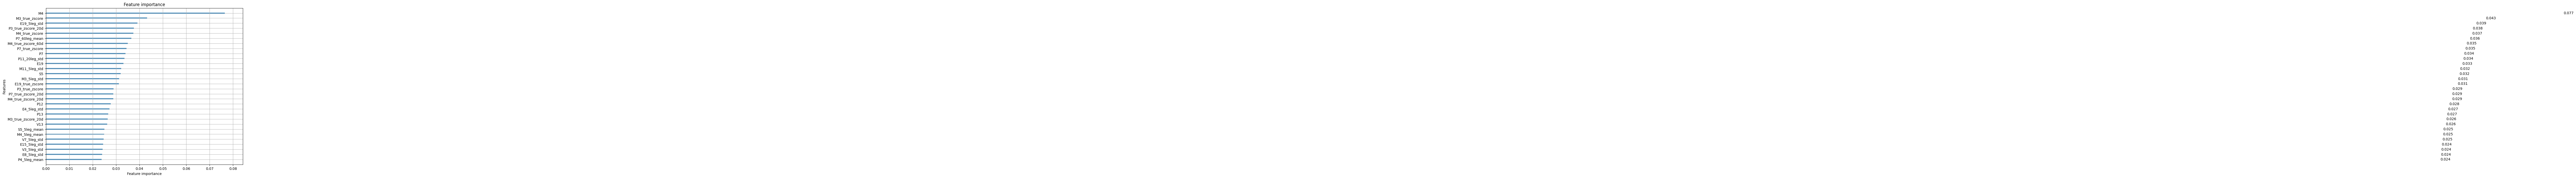

In [17]:
# M4 zscoreÏóêÏÑú 5ÏùºÎ≥¥Îã§ 20ÏùºÏù¥ Îçî Ï§ëÏöîÌï¥Ïßê -> Í∑∏Îüº Îã§Î•∏ ÌîºÏ≥êÎèÑ Í∑∏Îü¥ Í∞ÄÎä•ÏÑ± ÏûàÏùå/ Îçî Í∏¥Í≤ÉÎèÑ Ìï¥Î≥¥Ïûê
df_clean['M3_true_zscore_20d'] = (df_clean['M3'] - df_clean['M3'].rolling(20).mean()) / df_clean['M3'].rolling(20).std()

df_clean['P3_true_zscore_20d'] = (df_clean['P3'] - df_clean['P3'].rolling(20).mean()) / df_clean['P3'].rolling(20).std()

df_clean['M4_true_zscore_60d'] = (df_clean['M4'] - df_clean['M4'].rolling(60).mean()) / df_clean['M4'].rolling(60).std()

df_clean['M3_true_zscore_60d'] = (df_clean['M3'] - df_clean['M3'].rolling(60).mean()) / df_clean['M3'].rolling(60).std()

X_clean = df_clean.drop([label,'forward_returns', 'risk_free_rate','date_id'], axis=1)
y_clean = df_clean[label]

print("Íπ®ÎÅóÌïú Îç∞Ïù¥ÌÑ∞Î°ú ÌõàÎ†® ÏãúÏûë...")
model.fit(X_clean, y_clean) # <--- X_clean, y_clean ÏÇ¨Ïö©
print("ÌõàÎ†® ÎÅù")

plt.figure(figsize=(10,8))
lgb.plot_importance(
    model,
    max_num_features=30,
    importance_type='gain',
    figsize=(10,8)
)
plt.tight_layout()
plt.show()

Íπ®ÎÅóÌïú Îç∞Ïù¥ÌÑ∞Î°ú ÌõàÎ†® ÏãúÏûë...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120669
[LightGBM] [Info] Number of data points in the train set: 7984, number of used features: 518
[LightGBM] [Info] Start training from score 0.000069
ÌõàÎ†® ÎÅù


<Figure size 1000x800 with 0 Axes>

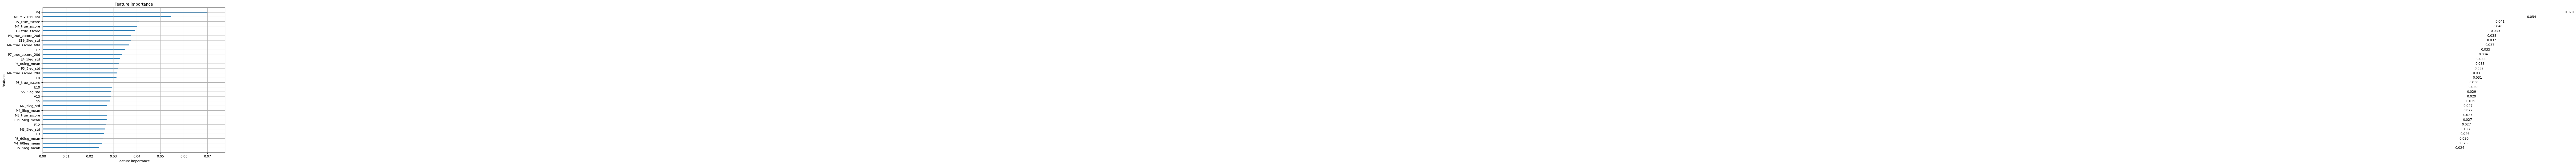

In [18]:
df_clean.drop(['M3_true_zscore_20d','M3_true_zscore_60d'], axis=1, inplace=True)

df_clean['M3_z_x_E19_std'] = df_clean['M3_true_zscore'] * df_clean['E19_5leg_std']

X_clean = df_clean.drop([label,'forward_returns', 'risk_free_rate','date_id'], axis=1)
y_clean = df_clean[label]

print("Íπ®ÎÅóÌïú Îç∞Ïù¥ÌÑ∞Î°ú ÌõàÎ†® ÏãúÏûë...")
model.fit(X_clean, y_clean) # <--- X_clean, y_clean ÏÇ¨Ïö©
print("ÌõàÎ†® ÎÅù")

plt.figure(figsize=(10,8))
lgb.plot_importance(
    model,
    max_num_features=30,
    importance_type='gain',
    figsize=(10,8)
)
plt.tight_layout()
plt.show()

Íπ®ÎÅóÌïú Îç∞Ïù¥ÌÑ∞Î°ú ÌõàÎ†® ÏãúÏûë...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 121179
[LightGBM] [Info] Number of data points in the train set: 7984, number of used features: 520
[LightGBM] [Info] Start training from score 0.000069
ÌõàÎ†® ÎÅù


<Figure size 1000x800 with 0 Axes>

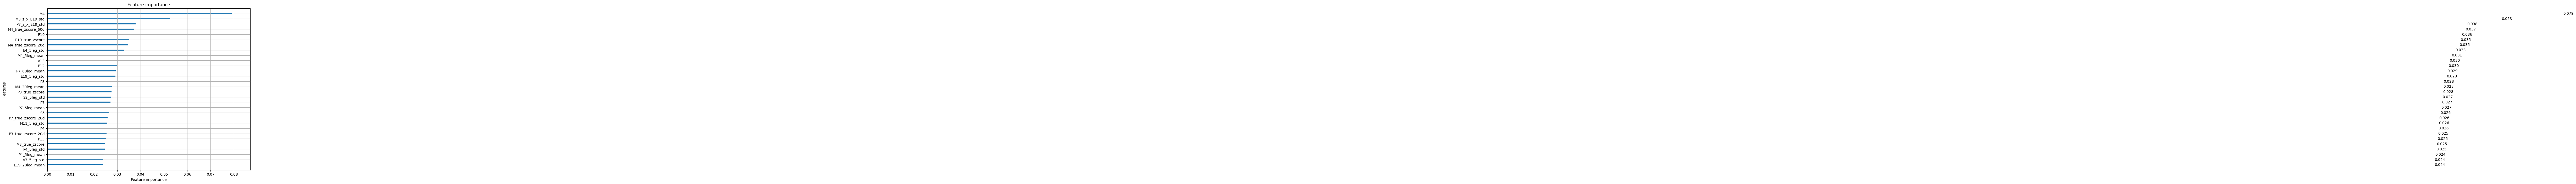

In [19]:
df_clean['P7_z_x_E19_std'] = df_clean['P7_true_zscore'] * df_clean['E19_5leg_std']

df_clean['M4_z_x_E19_std'] = df_clean['M4_true_zscore'] * df_clean['E19_5leg_std']

X_clean = df_clean.drop([label,'forward_returns', 'risk_free_rate','date_id'], axis=1)
y_clean = df_clean[label]

print("Íπ®ÎÅóÌïú Îç∞Ïù¥ÌÑ∞Î°ú ÌõàÎ†® ÏãúÏûë...")
model.fit(X_clean, y_clean) # <--- X_clean, y_clean ÏÇ¨Ïö©
print("ÌõàÎ†® ÎÅù")

plt.figure(figsize=(10,8))
lgb.plot_importance(
    model,
    max_num_features=30,
    importance_type='gain',
    figsize=(10,8)
)
plt.tight_layout()
plt.show()

Íπ®ÎÅóÌïú Îç∞Ïù¥ÌÑ∞Î°ú ÌõàÎ†® ÏãúÏûë...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 120159
[LightGBM] [Info] Number of data points in the train set: 7984, number of used features: 516
[LightGBM] [Info] Start training from score 0.000069
ÌõàÎ†® ÎÅù


<Figure size 1000x800 with 0 Axes>

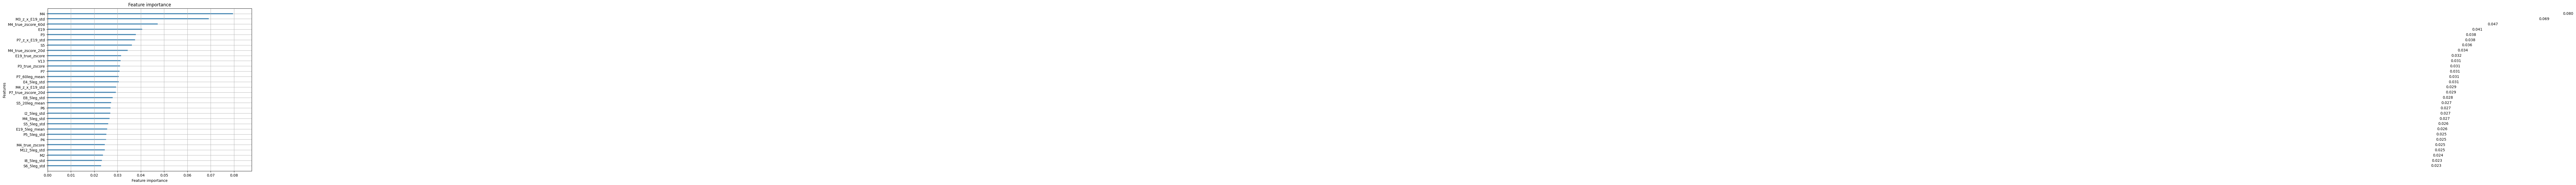

In [20]:
df_clean.drop(['M3_true_zscore','P7_true_zscore','P3_true_zscore_20d','P13'],axis=1,inplace=True)

X_clean = df_clean.drop([label,'forward_returns', 'risk_free_rate','date_id'], axis=1)
y_clean = df_clean[label]

print("Íπ®ÎÅóÌïú Îç∞Ïù¥ÌÑ∞Î°ú ÌõàÎ†® ÏãúÏûë...")
model.fit(X_clean, y_clean) # <--- X_clean, y_clean ÏÇ¨Ïö©
print("ÌõàÎ†® ÎÅù")

plt.figure(figsize=(10,8))
lgb.plot_importance(
    model,
    max_num_features=30,
    importance_type='gain',
    figsize=(10,8)
)
plt.tight_layout()
plt.show()

In [21]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error

print("ÌîºÏ≥ê Ï§ëÏöîÎèÑ Î™ÖÎã® ÏÉùÏÑ±...")
importance_df = pd.DataFrame({
    'feature':model.feature_name_,
    'importance':model.feature_importances_
}).sort_values(by='importance',ascending=False)

sorted_features = importance_df['feature'].tolist()

n_features_to_test = [20,30,40,50,len(sorted_features)]
experiment_results = {}

tscv = TimeSeriesSplit(n_splits=5)

lgb_params = {
    'objective': 'regression_l1',
    'metric': 'mae',
    'n_estimators': 1000, # early_stoppingÏùÑ Ïì∞ÎãàÍπå ÎÑâÎÑâÌïòÍ≤å
    'learning_rate': 0.01,
    'n_jobs': -1,
    'seed': 42,
    'verbose': -1,
}
print("=== ÌîºÏ≤ò Í∞úÏàòÎ≥Ñ ÏÑ±Îä• ÌÖåÏä§Ìä∏ ÏãúÏûë ===")
# --- 4. "Ï†ïÏòà Î©§Î≤Ñ" Ïàò Î≥ÑÎ°ú Î£®ÌîÑ ÏãúÏûë ---
for n in n_features_to_test:
    
    print(f"\n--- [ÌÖåÏä§Ìä∏ Ï§ë] ÏÉÅÏúÑ {n}Í∞ú ÌîºÏ≤ò ---")
    
    # 1. Î™ÖÎã®ÏóêÏÑú ÏÉÅÏúÑ nÍ∞ú ÌîºÏ≤ò Ïù¥Î¶ÑÎßå ÏûêÎ•¥Í∏∞
    top_n_features = sorted_features[:n]
    
    # 2. X_cleanÏóêÏÑú Îî± Í∑∏ nÍ∞ú Ïª¨ÎüºÎßå ÏÑ†ÌÉùÌïòÍ∏∞
    X_sliced = X_clean[top_n_features]
    
    fold_maes = [] # 5Í∞ú Ìè¥ÎìúÏùò MAE Ï†êÏàòÎ•º Îã¥ÏùÑ Î¶¨Ïä§Ìä∏
    
    # 3. TimeSeriesSplit ÍµêÏ∞®Í≤ÄÏ¶ù Ïã§Ìñâ
    for fold, (train_index, val_index) in enumerate(tscv.split(X_sliced)):
        
        # Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï† (ÏÉÅÏúÑ nÍ∞ú ÌîºÏ≤òÎßå Í∞ÄÏßÑ Îç∞Ïù¥ÌÑ∞Î°ú)
        X_train, X_val = X_sliced.iloc[train_index], X_sliced.iloc[val_index]
        y_train, y_val = y_clean.iloc[train_index], y_clean.iloc[val_index]

        # Î™®Îç∏ ÌõàÎ†®
        cv_model = lgb.LGBMRegressor(**lgb_params)
        cv_model.fit(X_train, y_train,
                     eval_set=[(X_val, y_val)],
                     eval_metric='mae',
                     callbacks=[lgb.early_stopping(100, verbose=False)])
        
        # Í≤ÄÏ¶ù
        val_preds = cv_model.predict(X_val)
        fold_mae = mean_absolute_error(y_val, val_preds)
        fold_maes.append(fold_mae)

    # 5Í∞ú Ìè¥ÎìúÏùò ÌèâÍ∑† MAE Í≥ÑÏÇ∞
    avg_mae = np.mean(fold_maes)
    print(f"[Í≤∞Í≥º] ÏÉÅÏúÑ {n}Í∞ú ÌîºÏ≤ò ÌèâÍ∑† MAE: {avg_mae:.6f}")
    experiment_results[n] = avg_mae

# --- 5. ÏµúÏ¢Ö Í≤∞Í≥º Î¶¨Ìè¨Ìä∏ ---
print("\n=== ÏµúÏ¢Ö Í≤∞Í≥º Î≥¥Í≥†ÏÑú ===")
best_n = min(experiment_results, key=experiment_results.get)
best_mae = experiment_results[best_n]

for n, mae in experiment_results.items():
    print(f"ÌîºÏ≤ò Í∞úÏàò: {n}Í∞ú | ÌèâÍ∑† MAE: {mae:.6f}")

print("\n-------------------------")
print(f"üéâ Î≤†Ïä§Ìä∏ Ï°∞Ìï©: ÏÉÅÏúÑ {best_n}Í∞ú ÌîºÏ≤ò (MAE: {best_mae:.6f})")
print("-------------------------")


ÌîºÏ≥ê Ï§ëÏöîÎèÑ Î™ÖÎã® ÏÉùÏÑ±...
=== ÌîºÏ≤ò Í∞úÏàòÎ≥Ñ ÏÑ±Îä• ÌÖåÏä§Ìä∏ ÏãúÏûë ===

--- [ÌÖåÏä§Ìä∏ Ï§ë] ÏÉÅÏúÑ 20Í∞ú ÌîºÏ≤ò ---
[Í≤∞Í≥º] ÏÉÅÏúÑ 20Í∞ú ÌîºÏ≤ò ÌèâÍ∑† MAE: 0.007858

--- [ÌÖåÏä§Ìä∏ Ï§ë] ÏÉÅÏúÑ 30Í∞ú ÌîºÏ≤ò ---
[Í≤∞Í≥º] ÏÉÅÏúÑ 30Í∞ú ÌîºÏ≤ò ÌèâÍ∑† MAE: 0.007858

--- [ÌÖåÏä§Ìä∏ Ï§ë] ÏÉÅÏúÑ 40Í∞ú ÌîºÏ≤ò ---
[Í≤∞Í≥º] ÏÉÅÏúÑ 40Í∞ú ÌîºÏ≤ò ÌèâÍ∑† MAE: 0.007852

--- [ÌÖåÏä§Ìä∏ Ï§ë] ÏÉÅÏúÑ 50Í∞ú ÌîºÏ≤ò ---
[Í≤∞Í≥º] ÏÉÅÏúÑ 50Í∞ú ÌîºÏ≤ò ÌèâÍ∑† MAE: 0.007852

--- [ÌÖåÏä§Ìä∏ Ï§ë] ÏÉÅÏúÑ 516Í∞ú ÌîºÏ≤ò ---
[Í≤∞Í≥º] ÏÉÅÏúÑ 516Í∞ú ÌîºÏ≤ò ÌèâÍ∑† MAE: 0.007854

=== ÏµúÏ¢Ö Í≤∞Í≥º Î≥¥Í≥†ÏÑú ===
ÌîºÏ≤ò Í∞úÏàò: 20Í∞ú | ÌèâÍ∑† MAE: 0.007858
ÌîºÏ≤ò Í∞úÏàò: 30Í∞ú | ÌèâÍ∑† MAE: 0.007858
ÌîºÏ≤ò Í∞úÏàò: 40Í∞ú | ÌèâÍ∑† MAE: 0.007852
ÌîºÏ≤ò Í∞úÏàò: 50Í∞ú | ÌèâÍ∑† MAE: 0.007852
ÌîºÏ≤ò Í∞úÏàò: 516Í∞ú | ÌèâÍ∑† MAE: 0.007854

-------------------------
üéâ Î≤†Ïä§Ìä∏ Ï°∞Ìï©: ÏÉÅÏúÑ 50Í∞ú ÌîºÏ≤ò (MAE: 0.007852)
-------------------------


In [22]:
# Ï§ëÏöîÌïú ÌîºÏ≥ê Î™ÖÎã®
N_BEST_FEATURE = 40

final_features_list = sorted_features[:N_BEST_FEATURE]

final_features_list

['M3_z_x_E19_std',
 'M4',
 'E19_true_zscore',
 'M4_true_zscore_60d',
 'P7_z_x_E19_std',
 'S5',
 'E19',
 'P4',
 'M4_true_zscore_20d',
 'P3',
 'M4_z_x_E19_std',
 'P3_true_zscore',
 'P7',
 'P7_true_zscore_20d',
 'M4_true_zscore',
 'P4_5leg_std',
 'E8_5leg_std',
 'M2',
 'I2_5leg_std',
 'I7_5leg_std',
 'M15_5leg_std',
 'V3',
 'S5_20leg_mean',
 'M4_5leg_std',
 'P4_5leg_mean',
 'P3_20leg_mean',
 'S6_5leg_std',
 'S5_5leg_mean',
 'S2_5leg_std',
 'M7_5leg_std',
 'V13',
 'V5_5leg_std',
 'M3',
 'M12_5leg_std',
 'E4_5leg_std',
 'M4_20leg_mean',
 'P3_5leg_mean',
 'P3_5leg_std',
 'P7_5leg_std',
 'P5_5leg_std']

In [23]:
X_final = df_clean[final_features_list]
y_final = df_clean[label]

final_model = lgb.LGBMRegressor(n_estimators=300, learning_rate=0.01)

final_model.fit(X_final, y_final)

print("ÏµúÏ¢Ö ÌõàÎ†® ÏôÑÎ£å")

# Î™®Îç∏ Ï†ÄÏû•
import joblib
joblib.dump(final_model, 'final_lgbm_model.pkl')

ÏµúÏ¢Ö ÌõàÎ†® ÏôÑÎ£å


['final_lgbm_model.pkl']